# Guided Project: Predicting House Sale Prices


In [128]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt


In [4]:
data = pd.read_csv('AmesHousing.tsv',delimiter="\t")

In [120]:
def transform_features(train):
    copie_train = train.copy()
    
    cols_suppr = list()
    ratio_null_cols = copie_train.isna().sum() / copie_train.count()
    
    for index,value in ratio_null_cols.items():
        if value>0.05:
            cols_suppr.append(index)
        
        elif value<0.05 and value>0:
            if (copie_train[index].dtypes =='float' 
                or copie_train[index].dtypes =='int'):
                copie_train[index] = copie_train[index].fillna(copie_train[index].mode())
            else:
                cols_suppr.append(index)
                
    ## Drop columns that aren't useful for ML
    cols_suppr.extend(["PID", "Order"])

    ## Drop columns that leak info about the final sale
    cols_suppr.extend(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"])                
    
    copie_train = copie_train.drop(columns=cols_suppr)
    
    copie_train['years_until_remod'] = copie_train['Year Remod/Add']-copie_train['Year Built']
    
    return copie_train

In [121]:
def select_features(train):
    copy = transform_features(train)
    coeff_corr = 0.3
    
    mat_corr = copy.corr()['SalePrice'].abs().sort_values()
    features = mat_corr[mat_corr>=coeff_corr].index.tolist()
    
    dataset = copy[features]
    
    dummies_col = ['Alley', 'Land Contour', 'Lot Config', 'Bldg Type', 'Mas Vnr Type', 'Misc Feature']
    
    for col in dummies_col:
        new_col = pd.get_dummies(train[col])
        dataset = pd.concat([dataset,new_col],axis=1)
        
    return dataset


In [129]:
def train_and_test(data,k=0):
    list_rmse = list()
    
    df = select_features(data)
    
    df[['Garage Cars','Mas Vnr Area',
          'Total Bsmt SF',
          'BsmtFin SF 1',
          'Garage Area']] = df[['Garage Cars','Mas Vnr Area',
          'Total Bsmt SF',
          'BsmtFin SF 1',
          'Garage Area']].fillna(0)
    
    num_cols = df.select_dtypes(include=['float','integer'])
    features = num_cols.columns.drop(['SalePrice'])
    
    if k==0:
        train = df[:1460]
        test = df[1460:]

        lr = LinearRegression()
        lr.fit(train[features],train['SalePrice'])

        prediction = lr.predict(test[features])

        mse = mean_squared_error(prediction,test['SalePrice'])

        list_rmse.append(mse**(1/2))
    
    if k==1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        
        train = df[:1460]
        test = df[1460:]
        
        lr = LinearRegression()
        lr.fit(train[features],train['SalePrice'])

        prediction = lr.predict(test[features])
        mse = mean_squared_error(prediction,test['SalePrice'])
        list_rmse.append(mse**(1/2))
    
        test = df[:1460]
        train = df[1460:]
        
        lr = LinearRegression()
        lr.fit(train[features],train['SalePrice'])

        prediction = lr.predict(test[features])
        mse = mean_squared_error(prediction,test['SalePrice'])
        list_rmse.append(mse**(1/2))
    
    if k>=2:
        kf = KFold(n_splits=k, shuffle=True)
        for train_index,test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            
            lr = LinearRegression()
            lr.fit(train[features],train['SalePrice'])

            prediction = lr.predict(test[features])
            mse = mean_squared_error(prediction,test['SalePrice'])
            list_rmse.append(mse**(1/2))
    
    return list_rmse


In [58]:
print(select_features(data).isna().sum())

Gr Liv Area    0
SalePrice      0
dtype: int64


In [59]:
print(select_features(data).max())

Gr Liv Area      5642
SalePrice      755000
dtype: int64


In [130]:
print(train_and_test(data))

[40121.7375165876]


In [131]:
print(train_and_test(data,1))

[40121.7375165876, 30194.368704392586]


In [132]:
print(train_and_test(data,5))

[28056.528586229568, 45166.17906840259, 34488.76957685843, 33913.31140219641, 25736.576266763135]


## Feature Engineering

In [69]:
print(transform_features(data).info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 59 columns):
MS SubClass          2930 non-null int64
MS Zoning            2930 non-null object
Lot Area             2930 non-null int64
Street               2930 non-null object
Lot Shape            2930 non-null object
Land Contour         2930 non-null object
Utilities            2930 non-null object
Lot Config           2930 non-null object
Land Slope           2930 non-null object
Neighborhood         2930 non-null object
Condition 1          2930 non-null object
Condition 2          2930 non-null object
Bldg Type            2930 non-null object
House Style          2930 non-null object
Overall Qual         2930 non-null int64
Overall Cond         2930 non-null int64
Year Built           2930 non-null int64
Year Remod/Add       2930 non-null int64
Roof Style           2930 non-null object
Roof Matl            2930 non-null object
Exterior 1st         2930 non-null object
Exterior 2nd     

## Feature Selection

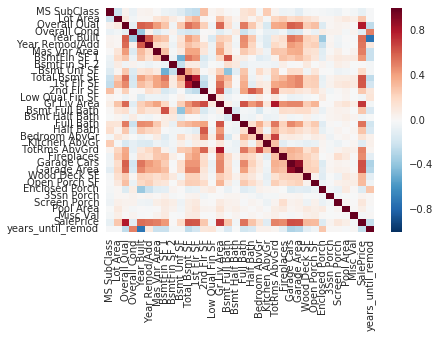

In [71]:
import seaborn as sns
%matplotlib inline
corr_mat = transform_features(data).corr()

sns.heatmap(corr_mat)


In [86]:
select_features(data)
#print(train_and_test(data))

,Open Porch SF,Wood Deck SF,BsmtFin SF 1,Fireplaces,TotRms AbvGrd,Mas Vnr Area,Year Remod/Add,Full Bath,Year Built,1st Flr SF,...,BrkCmn,BrkFace,CBlock,None,Stone,Elev,Gar2,Othr,Shed,TenC
0,62,210,639.0,2,7,112.0,1960,1,1960,1656,...,0,0,0,0,1,0,0,0,0,0
1,0,140,468.0,0,5,0.0,1961,1,1961,896,...,0,0,0,1,0,0,0,0,0,0
2,36,393,923.0,0,6,108.0,1958,1,1958,1329,...,0,1,0,0,0,0,1,0,0,0
3,0,0,1065.0,2,8,0.0,1968,2,1968,2110,...,0,0,0,1,0,0,0,0,0,0
4,34,212,791.0,1,6,0.0,1998,2,1997,928,...,0,0,0,1,0,0,0,0,0,0
5,36,360,602.0,1,7,20.0,1998,2,1998,926,...,0,1,0,0,0,0,0,0,0,0
6,0,0,616.0,0,6,0.0,2001,2,2001,1338,...,0,0,0,1,0,0,0,0,0,0
7,82,0,263.0,0,5,0.0,1992,2,1992,1280,...,0,0,0,1,0,0,0,0,0,0
8,152,237,1180.0,1,5,0.0,1996,2,1995,1616,...,0,0,0,1,0,0,0,0,0,0
9,60,140,0.0,1,7,0.0,1999,2,1999,1028,...,0,0,0,1,0,0,0,0,0,0


In [81]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

chosen_feature = list()

for feature in nominal_features:
    ratio = data[feature].value_counts()/data[feature].count()
    if len(ratio)<6 and ratio.max()<0.9:
        chosen_feature.append(feature)

print(chosen_feature)
    
    

['Alley', 'Land Contour', 'Lot Config', 'Bldg Type', 'Mas Vnr Type', 'Misc Feature']


In [5]:
data.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

## Train and Test

In [136]:
liste_rmse=list()

for k in range(0,20):
    rmse = np.average(train_and_test(data,k))
    print(rmse)
    liste_rmse.append(rmse)
    
print('--'*25)    
print(liste_rmse.index(min(liste_rmse)))


40121.7375165876
35158.053110490095
34011.87826629693
33780.398210609455
34199.658479495694
33467.896467613304
33308.570786566
32959.64126394769
33356.70090386134
33110.936416753684
33118.51282073432
32810.46543270803
33052.53699120295
32890.31527644039
32871.26396656784
32635.173011693285
32667.173990316922
32490.41870577676
32579.612723012597
32343.270171631968
--------------------------------------------------
19


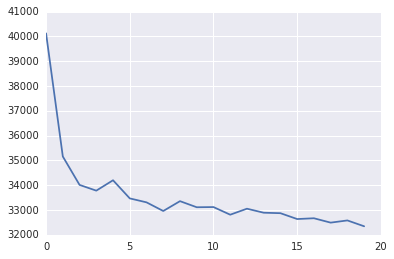

In [137]:
plt.plot(liste_rmse)
plt.show()